In [1]:
#!pip install kagglehub

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#####  1. Download and load a social media dataset from Kaggle. Display sample data and inspect the shape and content of the dataset

In [4]:
import pandas as pd
data=pd.read_csv("twcs.csv")
data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [5]:
data.shape

(2811774, 7)

In [6]:
# Sample 2000 rows

# We are sampling few random rows from the dataframe to reduce computational load
# Setting random_state ensures reproducibility of the sampled data
data = data.sample(n=3000, random_state=42)  # random_state for reproducibility
data.shape

(3000, 7)

In [7]:
data.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
160535,192624,161253,True,Wed Oct 04 13:59:33 +0000 2017,@161252 What's that egg website people talk about,192623,192625.0
659248,738238,296574,True,Fri Oct 06 18:29:06 +0000 2017,Why!🤷🏻‍♀️ #iOS11 @AppleSupport https://t.co/BX...,738237,NaN


#### 2. Inspect and import necessary libraries (e.g., pandas, nltk, re, matplotlib)


In [14]:
# 2. Inspect and import necessary libraries (e.g., pandas, nltk, re, matplotlib)
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')



#### 3. Explore the data. Use the pandas library


In [15]:
# 3. Explore the data. Use the pandas library
print("Dataset Info:")
data.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 160535 to 1812684
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tweet_id                 3000 non-null   int64         
 1   author_id                3000 non-null   object        
 2   inbound                  3000 non-null   bool          
 3   created_at               3000 non-null   datetime64[ns]
 4   text                     3000 non-null   object        
 5   response_tweet_id        1881 non-null   object        
 6   in_response_to_tweet_id  2175 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 167.0+ KB


In [16]:
data.describe()

,tweet_id,created_at,in_response_to_tweet_id
count,3.000000e+03,3000,2.175000e+03
mean,1.499497e+06,2017-11-02 18:10:47.856999936,1.465164e+06
min,1.291000e+03,2015-02-18 22:35:41,1.293000e+03
25%,7.448342e+05,2017-10-19 09:02:42.249999872,7.287460e+05
50%,1.489634e+06,2017-11-03 17:04:52,1.400851e+06
75%,2.252348e+06,2017-11-19 10:57:48.249999872,2.230058e+06
max,2.986906e+06,2017-12-03 21:47:24,2.986343e+06
std,8.642193e+05,NaN,8.668942e+05


In [17]:
print("Missing Values:")
data.isnull().sum()

Missing Values:


tweet_id                      0
author_id                     0
inbound                       0
created_at                    0
text                          0
response_tweet_id          1119
in_response_to_tweet_id     825
dtype: int64

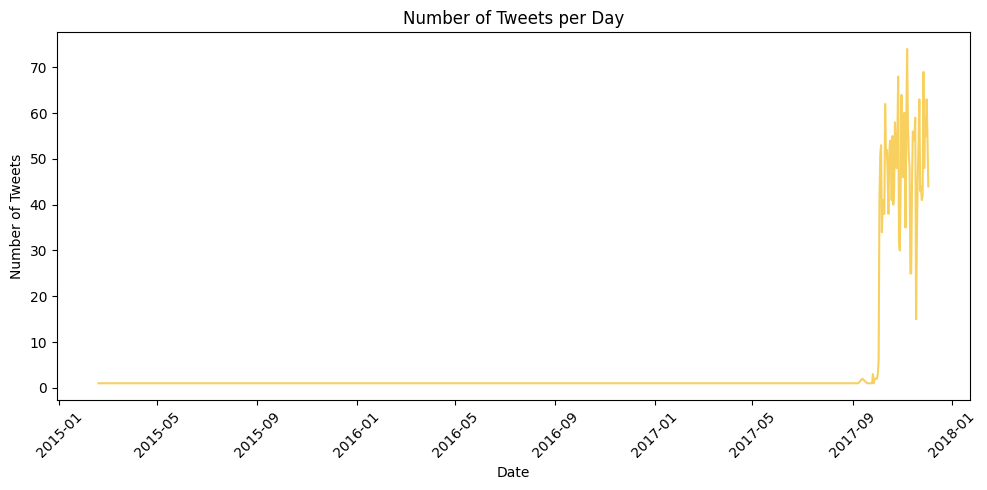

In [18]:
# Sub-step 1 Exploration: Plot tweet activity over time (convert created_at to datetime)
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
tweets_per_day = data.groupby(data['created_at'].dt.date).size()
plt.figure(figsize=(10, 5))
tweets_per_day.plot(kind='line', color='#F7D060')
plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
 data['author_id'].unique()

array(['161253', '296574', 'AppleSupport', ..., '365479', '335983',
       '368842'], shape=(1719,), dtype=object)

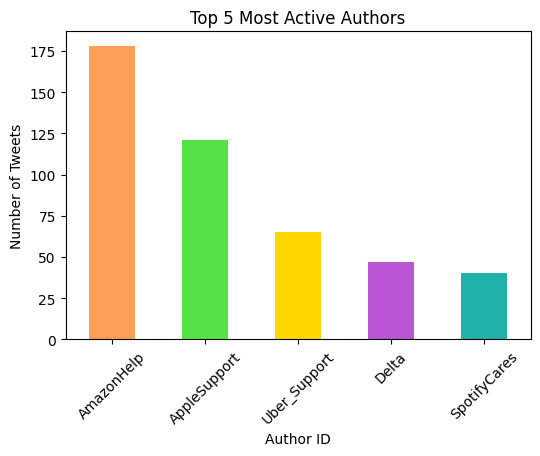

In [20]:
# Sub-step 2 Exploration: Count tweets by author (top 5 authors)
author_counts = data['author_id'].value_counts().head(5)
plt.figure(figsize=(6, 4))
author_counts.plot(kind='bar', color=['#FF9F55', '#54E346', '#FFD700', '#BA55D3', '#20B2AA'])
plt.title('Top 5 Most Active Authors')
plt.xlabel('Author ID')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

## The best approach is to handle negations first (e.g., replacing "not good" with "not_good") before cleaning and tokenization, ensuring the negation context is preserved. Then, clean the text while keeping underscores in negation tokens intact.

#### 4. Preprocess the tweets: Write a function to clean the text


In [21]:
# Step 4: Preprocess the text
# Negation dictionary
slang_dict = {
    "not good": "not_good",
    "not okay": "not_okay",
    "not happy": "not_happy",
    "can't": "cannot",
    "won't": "will_not",
    "don't": "do_not"
}

# Function to replace negations and slang
def replace_negations(text, slang_dict):
    for key, value in slang_dict.items():
        text = re.sub(r'\b' + key + r'\b', value, text, flags=re.IGNORECASE)
    return text

# Clean text function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace negations first
    text = replace_negations(text, slang_dict)
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', text, flags=re.MULTILINE)
    # Remove punctuation except underscore
    text = re.sub(r'[^\w\s_]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords, keep negation tokens
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words or '_' in token]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) if '_' not in token else token for token in tokens]
    return tokens

In [22]:
# Before : containing "not good" or "can't" before replacement 
data[data['text'].str.contains("not good|can't", regex=True, na=False)].head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
71421,92536,136038,True,2017-11-30 14:15:38,@AppleSupport whenever I BUY a song or album o...,92535,NaN
609891,683792,283194,True,2017-11-27 07:41:52,"@AmazonHelp Hi, the new unit went off twice ov...",683794,683791.0
2223292,2386707,442234,True,2017-10-20 10:05:47,@AmericanAir hi do you not have direct flights...,2386706,NaN
69585,89915,135480,True,2017-11-30 14:29:50,@BofA_Help acct 7452 V Vanorden. why can't i...,"89914,89916",NaN
1408857,1550591,479907,True,2017-11-04 02:36:33,@AirbnbHelp I can't get help on the website. S...,1550590,NaN


In [23]:
data['Cleaned_Tweet'] = data['text'].apply(clean_text)  

In [24]:
data[data['Cleaned_Tweet'].str.contains("not good|can't", regex=True, na=False)].head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,Cleaned_Tweet


#### Step 5-6: Replace slang/negations (handled in clean_text), implement negation (done)

#### 7. Remove or convert emojis (e.g., using the emoji library)


In [25]:
import emoji

def remove_emoji(tweet):
   
    cleaned_tokens = []
    for token in tweet:
        if '_' not in token:
            cleaned_tokens.append(emoji.demojize(token))
        else:
            cleaned_tokens.append(token)
    return cleaned_tokens

# Apply the function to the 'Cleaned_Tweet' column
data['Cleaned_Tweet'] = data['Cleaned_Tweet'].apply(remove_emoji)


#### Step 8: Store cleaned text
- Already stored in 'Cleaned_Tweet' column



#### Step 9: Save to CSV


In [26]:
data.to_csv('cleaned_dataset.csv', index=False)

#### Step 10: Visualize results with word cloud

In [27]:
from collections import Counter

# Initialize an empty list to store all words
all_words = []

# Iterate through each tweet in the 'Cleaned_Tweet' column
for sublist in data['Cleaned_Tweet']:
    # Iterate through each word in the tweet
    for word in sublist:
        all_words.append(word)

# Count the frequency of each word
word_freq = Counter(all_words)

# Display the most common words
print("Most frequent words:", word_freq.most_common(20))


Most frequent words: [('u', 536), ('please', 441), ('dm', 382), ('help', 280), ('hi', 247), ('thanks', 242), ('get', 207), ('sorry', 188), ('im', 167), ('like', 166), ('know', 166), ('look', 165), ('issue', 159), ('send', 157), ('let', 156), ('service', 152), ('number', 151), ('account', 151), ('time', 149), ('well', 141)]


In [28]:
! pip install wordcloud


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


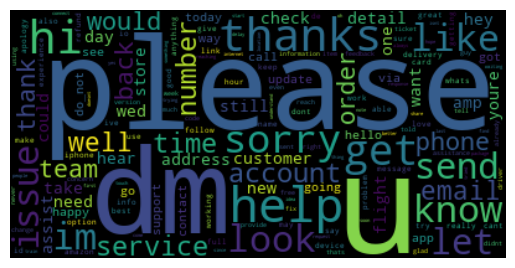

In [29]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()